In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Circle, Rectangle
from matplotlib.animation import FuncAnimation
plt.rcParams.update({
    'figure.figsize': (4.8, 2.7), 'font.size': 15,
    'lines.linewidth': 2,
    'xtick.labelsize': 'small', 'ytick.labelsize': 'small',
    'axes.spines.top': False, 'axes.spines.right': False,
    'savefig.dpi': 200,
})

from pathlib import Path
import numpy as np
import torch
from jarvis.utils import tqdm

rng = np.random.default_rng()
FIG_PATH = Path('../figures')

In [2]:
def vals2map(vals):
    if vals.shape==(256,):
        map = vals.reshape(16, 16).copy()
    elif vals.shape==(1024,):
        offsets = [(0, 0), (0, 1), (1, 0), (1, 1)]
        assert vals.shape==(1024,)
        map = np.full((32, 32), fill_value=np.nan)
        for i, (y, x) in enumerate(offsets):
            map[y::2, x::2] = vals[i*256:(i+1)*256].reshape(16, 16)
    else:
        raise ValueError(f"Incorrect shape: {vals.shape}")
    return map

In [3]:
from bisc import rcParams

rcParams['stimulus_path'] = '/mnt/d/BISC_2023/stimulus'
rcParams['response_path'] = '/mnt/d/BISC_2023/response'

In [4]:
from bisc.data import get_session, get_num_channels, get_valid_idxs
from bisc.dot import dot_triggered_average, get_rf_data, plot_rf_snapshots

TILES = [
    '39491886', '48683828', '02187077', '19889837',
    '22652138', '25394938', '27832912', '31080823',
    '05454007', '09690755', '76995123', '98782621',
    '07586668', '80605801', '37721134', '39666903',
]

In [23]:
tile_idx = 11
session_id = TILES[tile_idx-1]
session = get_session(session_id)
num_channels = get_num_channels(session)

trial_idxs, channel_idxs = get_valid_idxs(session)

dt = 0.5
transform = {'type': 'remove_mean'}
xs, ys, taus, responses_mean, _, _ = dot_triggered_average(session, dt=dt, transform=transform)

In [24]:
saved = torch.load('../cache/RF.fit_tile{:02d}.pt'.format(tile_idx))
fvus = saved['fvus']
mask = fvus>0.8
rfs_s0, rfs_s1 = saved['rfs_s0'], saved['rfs_s1']
rfs_t0, rfs_t1 = saved['rfs_t0'], saved['rfs_t1']
params_s0, params_s1 = saved['params_s0'], saved['params_s1']
A0 = ((rfs_t0[:, :, None, None]*rfs_s0[:, None, :, :])**2).mean(axis=(1, 2, 3))
A1 = ((rfs_t1[:, :, None, None]*rfs_s1[:, None, :, :])**2).mean(axis=(1, 2, 3))

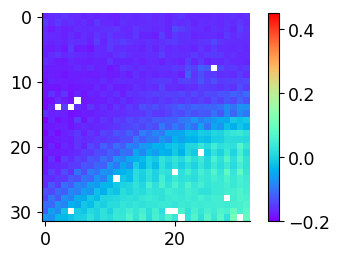

In [25]:
fig, ax = plt.subplots()
vals = params_s0[:, 1].copy()
vals[mask] = np.nan
h = ax.imshow(vals2map(vals), vmin=-0.2, vmax=0.45, cmap='rainbow')
fig.colorbar(h)
plt.show()

In [33]:
(params_s0[:, 1]>0.05).nonzero()

(array([ 175,  189,  190,  191,  204,  205,  206,  207,  216,  217,  218,
         219,  220,  222,  223,  236,  237,  239,  254,  255,  495,  502,
         503,  504,  506,  507,  508,  509,  510,  511,  684,  687,  703,
         717,  718,  719,  735,  751,  866,  965,  991, 1007, 1014, 1015,
        1016, 1017, 1018, 1019, 1020, 1021, 1022, 1023]),)

Channel 110


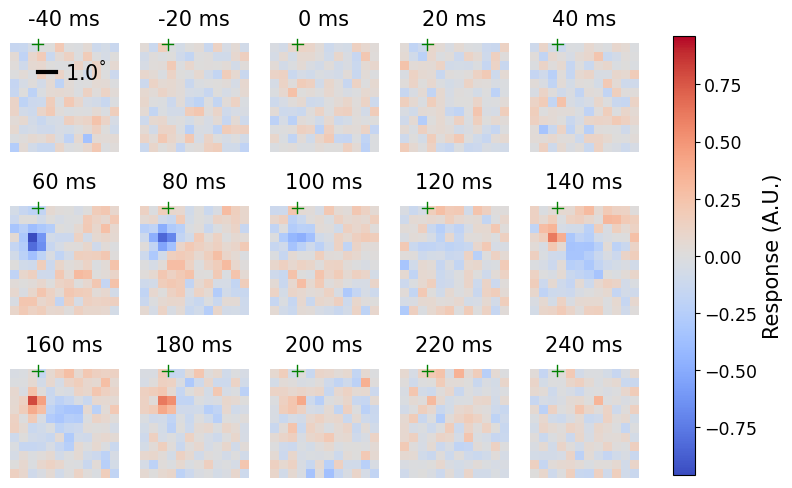

Channel 190


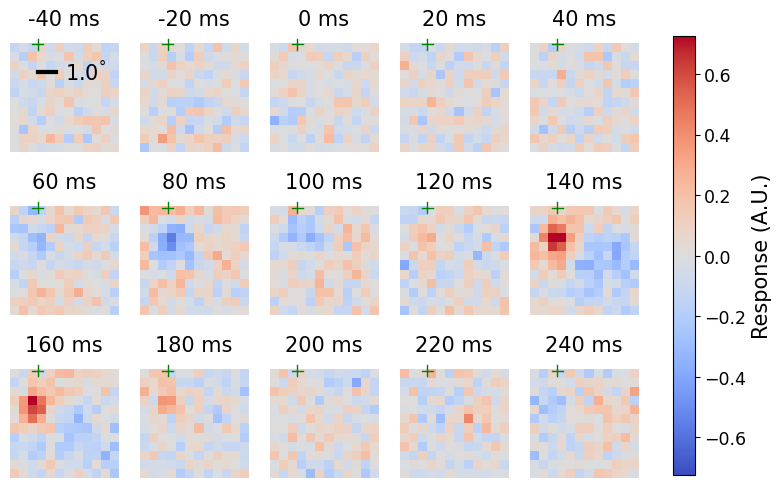

In [37]:
channel_idx = 110
print(f'Channel {channel_idx}')
_, rf_data, _, _, _ = get_rf_data(session, channel_idx, dt=dt, transform=transform)
vlim = np.abs(rf_data).max()*0.8
fig, axes = plot_rf_snapshots(
    rf_data, xs, ys, taus, vmin=-vlim, vmax=vlim,
)
plt.show()

channel_idx = 190
print(f'Channel {channel_idx}')
_, rf_data, _, _, _ = get_rf_data(session, channel_idx, dt=dt, transform=transform)
vlim = np.abs(rf_data).max()*0.8
fig, axes = plot_rf_snapshots(
    rf_data, xs, ys, taus, vmin=-vlim, vmax=vlim,
)
plt.show()

In [29]:
from bisc.dot import gabor_1d, gauss_2d
from scipy.optimize import minimize

def fit_gauss_2d(rf_s, xs, ys, sigma_lim, num_optims=200):
    _ys, _xs = np.meshgrid(ys, xs, indexing='ij')
    vlim = np.abs(rf_s).max()
    func = lambda param: gauss_2d(_xs, _ys, *param)
    bounds = (
        (0, 3*vlim), (-2, 4), (-1, 5), sigma_lim, (-vlim, vlim),
    )

    min_loss, param = float('inf'), None
    for _ in range(num_optims):
        res = minimize(lambda param: ((func(param)-rf_s)**2).mean(),
            [rng.uniform(l, h) for l, h in bounds], bounds=bounds,
        )
        if res.fun<min_loss:
            min_loss = res.fun
            param = res.x
    rf_fit = func(param)
    return rf_fit, param

def get_rf_s(rf_data, rf_t, taus, xs, ys, sigma_lim=(0.1, 1), num_optims=200):
    # rf_fit_t, _ = fit_gabor_1d(rf_t, taus, num_optims)
    # rf_fit_t = rf_fit_t/(rf_fit_t**2).sum()**0.5
    # rf_s = (rf_data*rf_fit_t[:, None, None]).sum(axis=0)
    rf_s = (rf_data*rf_t[:, None, None]).sum(axis=0)
    rf_fit_s, param_s = fit_gauss_2d(rf_s, xs, ys, sigma_lim, num_optims)
    return rf_fit_s, param_s

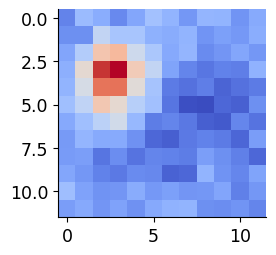

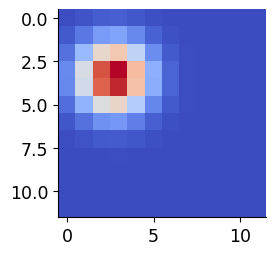

In [53]:
rf_s0 = (rf_data*rfs_t0[channel_idx][:, None, None]).sum(axis=0)
_, ax = plt.subplots()
ax.imshow(rf_s0, cmap='coolwarm')
plt.show()
_, ax = plt.subplots()
ax.imshow(rf_fit_s0, cmap='coolwarm')
plt.show()

Channel 190


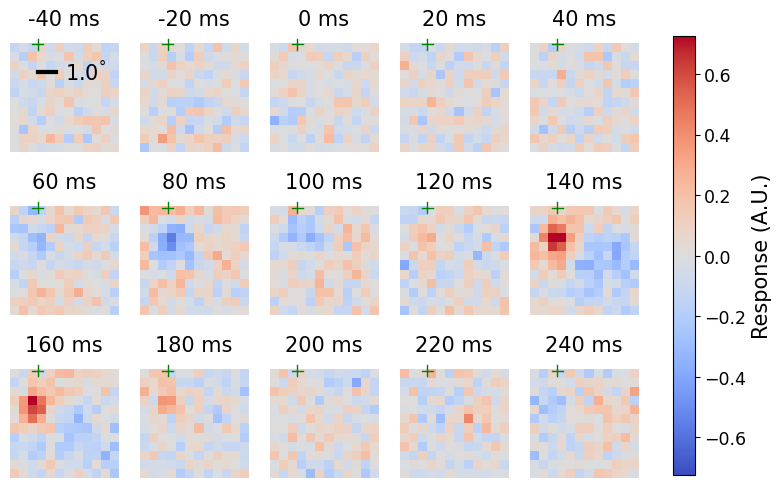

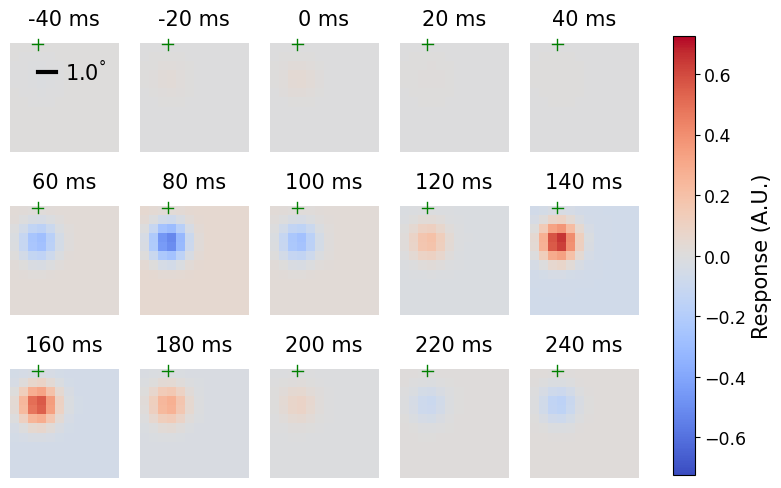

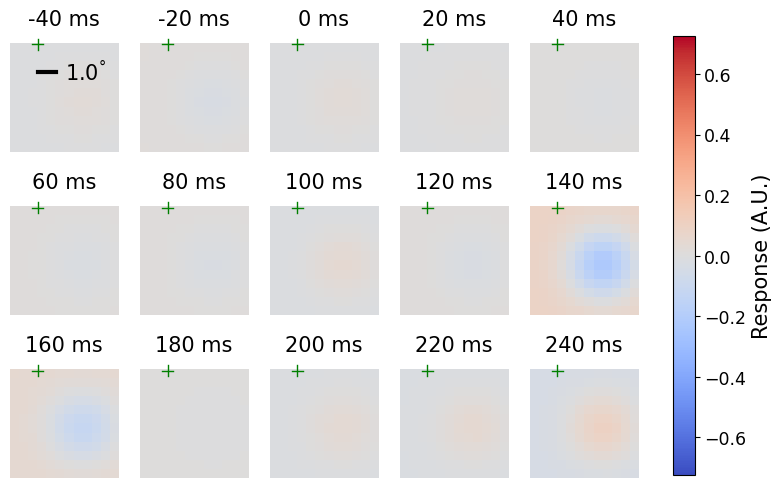

rank-2 approx
[ 8.7942361   0.06917473  1.92247769  0.68615785 -0.71527512]
[ 2.41521626  2.47925594  3.1615528   1.32167715 -0.6711004 ]
R2: 35%


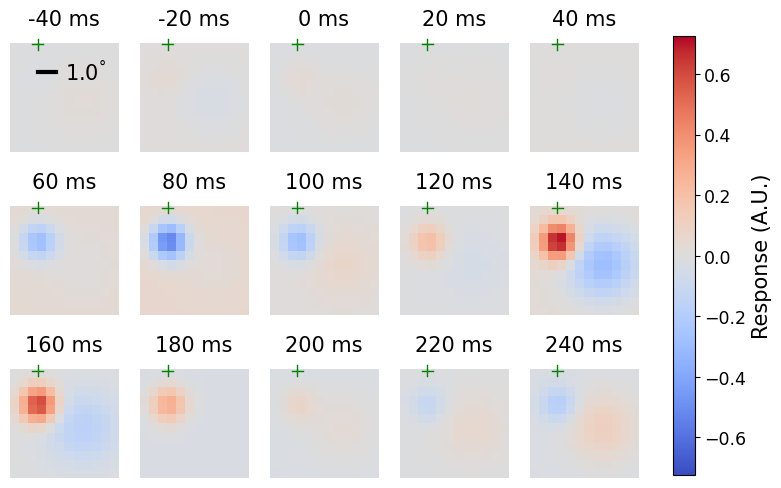

In [49]:
saved = torch.load('../cache/RF.temporal_v3.pt')
u0 = saved['u0']
u1 = saved['u1']
num_optims = 100

# channel_idx = rng.choice(channel_idxs)
channel_idx = 190
print(f'Channel {channel_idx}')

_, rf_data, _, _, _ = get_rf_data(session, channel_idx, dt=dt, transform=transform)
vlim = np.abs(rf_data).max()*0.8
fig, axes = plot_rf_snapshots(
    rf_data, xs, ys, taus, vmin=-vlim, vmax=vlim,
)
plt.show()

u, _, _ = np.linalg.svd(rf_data.reshape(len(taus), -1))
# if (u0*u[:, 0]).sum()>0:
#     rf_t0 = u[:, 0]
# else:
#     rf_t0 = -u[:, 0]
rf_t0 = u0
rf_fit_s0, _ = get_rf_s(rf_data, rf_t0, taus, xs, ys, (0.1, 1), num_optims)
rf_fit_s0 /= (rf_fit_s0**2).sum()**0.5
rf_t0 = (rf_data*rf_fit_s0).sum(axis=(1, 2))
rf_t0 /= (rf_t0**2).sum()**0.5
rf_fit_s0, param_s0 = get_rf_s(rf_data, rf_t0, taus, xs, ys, (0.1, 1), num_optims)
rf_fit0 = rf_t0[:, None, None]*rf_fit_s0[None]

rf_t1 = u1
rf_fit_s1, param_s1 = get_rf_s(rf_data-rf_fit0, rf_t1, taus, xs, ys, (0.2, 3), num_optims)
rf_fit_s1 /= (rf_fit_s1**2).sum()**0.5
rf_t1 = ((rf_data-rf_fit0)*rf_fit_s1).sum(axis=(1, 2))
rf_t1 /= (rf_t1**2).sum()**0.5
rf_fit_s1, param_s1 = get_rf_s(rf_data-rf_fit0, rf_t1, taus, xs, ys, (0.2, 3), num_optims)
rf_fit1 = rf_t1[:, None, None]*rf_fit_s1[None]

rf_t0 = u0
rf_fit_s0, _ = get_rf_s(rf_data-rf_fit1, rf_t0, taus, xs, ys, (0.1, 1), num_optims)
rf_fit_s0 /= (rf_fit_s0**2).sum()**0.5
rf_t0 = ((rf_data-rf_fit1)*rf_fit_s0).sum(axis=(1, 2))
rf_t0 /= (rf_t0**2).sum()**0.5
rf_fit_s0, param_s0 = get_rf_s(rf_data-rf_fit1, rf_t0, taus, xs, ys, (0.1, 1), num_optims)
rf_fit0 = rf_t0[:, None, None]*rf_fit_s0[None]

fig, axes = plot_rf_snapshots(
    rf_fit0, xs, ys, taus, vmin=-vlim, vmax=vlim,
)
fig, axes = plot_rf_snapshots(
    rf_fit1, xs, ys, taus, vmin=-vlim, vmax=vlim,
)
plt.show()

print('rank-2 approx')
print(param_s0)
print(param_s1)
rf_fit = rf_fit0+rf_fit1
fig, axes = plot_rf_snapshots(
    rf_fit, xs, ys, taus, vmin=-vlim, vmax=vlim,
)

fvu = ((rf_fit-rf_data)**2).mean()/rf_data.var()
print('R2: {:.0%}'.format(1-fvu))

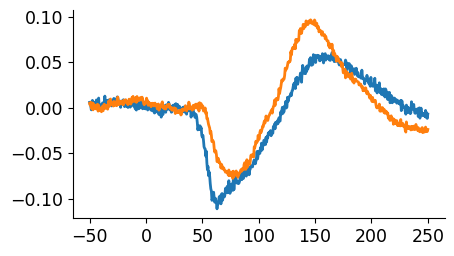

In [48]:
_, ax = plt.subplots()
# ax.plot(taus, u0)
# ax.plot(taus, -u[:, 0])
ax.plot(taus, rfs_t0[110])
ax.plot(taus, rfs_t0[190])
plt.show()

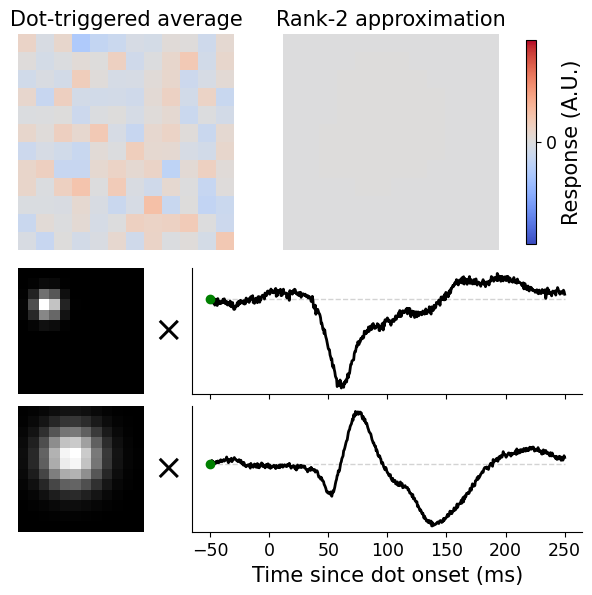

  0%|                                                                                                         …

In [9]:
vlim = np.abs(rf_data).max()*0.6

fig = plt.figure(figsize=(6, 6))
axes = []
ax = fig.add_axes([0.03, 0.55, 0.4, 0.4])
axes.append(ax)
h_data = ax.imshow(rf_data[0], vmin=-vlim, vmax=vlim, cmap='coolwarm')
ax.axis('off')
ax.set_title('Dot-triggered average', fontsize='medium')
ax = fig.add_axes([0.52, 0.55, 0.4, 0.4])
axes.append(ax)
h_fit = ax.imshow(rf_fit[0], vmin=-vlim, vmax=vlim, cmap='coolwarm')
ax.axis('off')
ax.set_title('Rank-2 approximation', fontsize='medium')
plt.colorbar(h_data, ax=axes, shrink=0.85, fraction=0.05, ticks=[0], label='Response (A.U.)')
ax = fig.add_axes([0.03, 0.33, 0.21, 0.21])
ax.imshow(rf_fit_s0, cmap='gray')
ax.axis('off')
ax = fig.add_axes([0.32, 0.33, 0.65, 0.21])
ax.plot(taus, np.zeros(taus.shape), color='lightgray', linewidth=1, linestyle='--')
ax.plot(taus, rf_t0, color='black', linewidth=2)
h_t0 = ax.scatter(taus[0], rf_t0[0], marker='o', color='green', zorder=2)
ax.set_ylabel(r'$\times$', fontsize='xx-large')
ax.set_yticks([])
ax.set_xticklabels([])
ax = fig.add_axes([0.03, 0.1, 0.21, 0.21])
ax.imshow(rf_fit_s1, cmap='gray')
ax.axis('off')
ax = fig.add_axes([0.32, 0.1, 0.65, 0.21])
ax.plot(taus, np.zeros(taus.shape), color='lightgray', linewidth=1, linestyle='--')
ax.plot(taus, rf_t1, color='black', linewidth=2)
h_t1 = ax.scatter(taus[0], rf_t1[0], marker='o', color='green', zorder=2)
ax.set_ylabel(r'$\times$', fontsize='xx-large')
ax.set_yticks([])
ax.set_xlabel(r'Time since dot onset (ms)')
plt.show()

play_every = 4
fps = 20/(taus[1]-taus[0])/play_every
with tqdm(total=len(taus)//play_every+3, unit='frame', leave=True) as pbar:
    def update(t):
        _t = t*play_every
        h_data.set_data(rf_data[_t])
        h_fit.set_data(rf_fit[_t])
        h_t0.set_offsets(np.array([taus[_t], rf_t0[_t]])[None])
        h_t1.set_offsets(np.array([taus[_t], rf_t1[_t]])[None])
        pbar.update()
        return h_data, h_fit, h_t0, h_t1
    ani = FuncAnimation(fig, update, frames=len(taus)//play_every, blit=True)
    ani.save('two.components.mp4', fps=fps)